# Workforce Resilience
### Simulating Employer-Level Workforce Risk Using Public Labor Data

---
## **Executive Summary**

This analysis develops a Workforce Resilience framework to evaluate structural stability and downside risk across major industry segments. Using JOLTS and CES data, I construct a composite Resilience Index combining hiring volatility (stability signal) and net hiring strength (expansion signal), then examine its relationship with subsequent employment growth.

Results suggest that elevated hiring volatility can signal labor market dynamism rather than fragility, with higher volatility positively associated with future employment growth in the sample period.

To translate industry-level signals into employer-level insight, I simulate firm-level workforce exposure using archetype-based industry portfolios and introduce firm-specific labor sensitivity. This enables construction of two complementary metrics:

- **RAES (Resilience-Adjusted Employment Share):** Employment-weighted structural workforce stability  
- **ARES (Adjusted Risk-Exposed Share):** Employment-weighted downside vulnerability adjusted for labor sensitivity  

The simulation highlights how sector concentration can amplify aggregate workforce risk, even when overall resilience appears elevated.

This notebook demonstrates end-to-end analytical capabilities including metric design, panel modeling, simulation-based exposure modeling, and data visualization.

## Data Munging

### Imports & Configurations

In [ ]:
# Imports & Configs
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf
from sklearn.preprocessing import MinMaxScaler

sns.set(style="whitegrid")
pd.set_option("display.max_columns", None)

### Load Data

In [ ]:
#Load Data
jolts = pd.read_csv("/data/jolts.csv")
ces = pd.read_csv("/data/ces.csv")

jolts['date'] = pd.to_datetime(jolts['date']).dt.to_period('M')
ces['date'] = pd.to_datetime(ces['date']).dt.to_period('M')

print("JOLTS shape:", jolts.shape)
print("CES shape:", ces.shape)

JOLTS shape: (576, 4)
CES shape: (580, 3)


### Data Standardization & SQL-Style Join

In [ ]:
# Filter industries of interest
industries = ["Manufacturing", "Information", "Health care and social assistance"]

jolts = jolts[jolts['industry'].isin(industries)]
ces = ces[ces['industry'].isin(industries)]

# SQL-style join on industry + date
df = jolts.merge(
    ces,
    on=["date", "industry"],
    how="left",
    validate="many_to_one"
)

df.head()

,date,industry,hires,separations,employment
0,2010-01,Manufacturing,225,244,11447.0
1,2010-02,Manufacturing,256,269,11439.0
2,2010-03,Manufacturing,257,261,11439.0
3,2010-04,Manufacturing,278,246,11475.0
4,2010-05,Manufacturing,254,220,11511.0


### Data Integration Strategy

We combine labor *flow* data (hires, separations) with employment *stock* data.

This mirrors workforce intelligence systems that join:

- Talent inflows/outflows  
- Firm headcount levels  
- Industry benchmarks  

This integration allows normalized rate calculations.

## Feature Engineering



### Workforce Flow Metrics

In [ ]:
df = df.sort_values(["industry", "date"])

df["net_hiring"] = df["hires"] - df["separations"]
df["hire_rate"] = df["hires"] / df["employment"]
df["separation_rate"] = df["separations"] / df["employment"]

# Rolling volatility (6-month)
df["hire_volatility"] = (
    df.groupby("industry")["hire_rate"]
    .transform(lambda x: x.rolling(6).std())
)

df.tail()

,date,industry,hires,separations,employment,net_hiring,hire_rate,separation_rate,hire_volatility
187,2025-08,Manufacturing,305,313,12615.0,-8,0.024178,0.024812,0.001423
188,2025-09,Manufacturing,320,327,12612.0,-7,0.025373,0.025928,0.001453
189,2025-10,Manufacturing,317,319,12603.0,-2,0.025153,0.025311,0.001242
190,2025-11,Manufacturing,282,301,12593.0,-19,0.022393,0.023902,0.001141
191,2025-12,Manufacturing,287,311,12585.0,-24,0.022805,0.024712,0.001206


### Workforce Resilience Index Construction

The first five months within each industry are excluded because rolling volatility is based on a six-month window; retaining incomplete windows would mechanically suppress early volatility estimates. Volatility is then normalized within industry to account for persistent structural differences in turnover dynamics. This ensures the index captures cyclical workforce stress rather than cross-industry differences in baseline volatility.
<br><br>

Weights are equally assigned to volatility and net hiring to reflect
both stability and growth dimensions of workforce health.

Alternative weighting schemes could be tested using:
* Historical predictive power
* Principal component analysis
* Client-specific priorities

In [ ]:
# Removing NaN hire_valatility
df_valid = df.dropna(subset=["hire_volatility"]).copy()

# Within industry Min-Max scaling
df_valid["vol_scaled"] = (
    df_valid.groupby("industry")["hire_volatility"]
    .transform(lambda x: (x - x.min()) / (x.max() - x.min()))
)
df_valid["net_scaled"] = (
    df_valid.groupby("industry")["net_hiring"]
    .transform(lambda x: (x - x.min()) / (x.max() - x.min()))
)

# Define resilience as:
# Lower volatility + stronger net hiring
df_valid["resilience_index"] = (
    (1 - df_valid["vol_scaled"]) * 0.5 +
    df_valid["net_scaled"] * 0.5
)

df_valid.head()

,date,industry,hires,separations,employment,net_hiring,hire_rate,separation_rate,hire_volatility,vol_scaled,net_scaled,resilience_index
389,2010-06,Health care and social assistance,428,415,16803.6,13,0.025471,0.024697,0.000855,0.049641,0.710127,0.830243
390,2010-07,Health care and social assistance,458,436,16816.3,22,0.027235,0.025927,0.001218,0.082188,0.715823,0.816817
391,2010-08,Health care and social assistance,391,379,16845.3,12,0.023211,0.022499,0.001437,0.101847,0.709494,0.803823
392,2010-09,Health care and social assistance,432,415,16854.5,17,0.025631,0.024623,0.001459,0.103794,0.712658,0.804432
393,2010-10,Health care and social assistance,409,378,16889.3,31,0.024217,0.022381,0.001469,0.104674,0.721519,0.808423


### Constructing the Workforce Resilience Index

The Workforce Resilience Index combines two complementary labor market signals:

1. **Hiring Volatility (Stability Component)**  
   Rolling hiring volatility captures instability in workforce dynamics. Higher volatility reflects greater uncertainty, turnover pressure, or rapid shifts in demand.

2. **Net Hiring Strength (Expansion Component)**  
   Net hiring captures whether workforce growth is structurally positive or contracting.

The index is constructed as:

$$
\ Resilience = 0.5 \times (1 - Volatility_{scaled}) + 0.5 \times NetHiring_{scaled}
$$

Both components are min–max scaled within industry to ensure comparability over time.

Equal weighting is used as a neutral baseline. In a production setting, weights could be optimized empirically (e.g., via predictive validation against employment contraction events).

This formulation balances structural stability (low volatility) with forward momentum (positive net hiring).

### Industry-level Trend Visualization

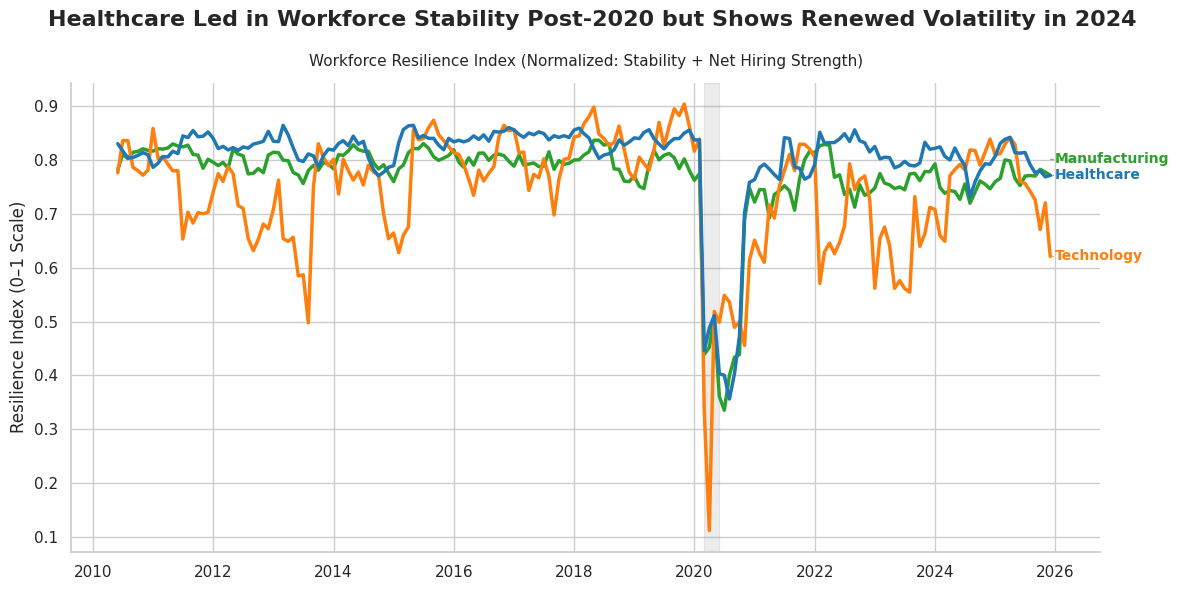

In [ ]:
# Simplifying Naming
label_map = {
    "Health care and social assistance": "Healthcare",
    "Information": "Technology",
    "Manufacturing": "Manufacturing"
}

# Industry Color Palettes
palette = {
    "Health care and social assistance": "#1f77b4",
    "Information": "#ff7f0e",
    "Manufacturing": "#2ca02c"
}

fig, ax = plt.subplots(figsize=(12,6))

endpoints = []

for ind in industries:
    subset = df_valid[df_valid["industry"] == ind]
    x = subset["date"].dt.to_timestamp()
    y = subset["resilience_index"]

    ax.plot(x, y, linewidth=2.5, color=palette.get(ind))

    endpoints.append({
        "industry": ind,
        "x": x.iloc[-1],
        "y_true": y.iloc[-1],
        "y": y.iloc[-1],
        "color": palette.get(ind, "black")
    })

# Prevent Label Overlap
endpoints = sorted(endpoints, key=lambda d: d["y"])

min_gap = 0.03

for i in range(1, len(endpoints)):
    if endpoints[i]["y"] - endpoints[i-1]["y"] < min_gap:
        endpoints[i]["y"] = endpoints[i-1]["y"] + min_gap




# Add Labels + Connector Lines
for point in endpoints:
    # connector
    ax.plot(
        [point["x"], point["x"] + pd.Timedelta(days=20)],
        [point["y"], point["y"]],
        color=point["color"],
        linewidth=1,
        alpha=0.6
    )

    # colored label
    ax.text(
        point["x"] + pd.Timedelta(days=30),
        point["y"],
        label_map.get(point["industry"], point["industry"]),
        fontsize=10,
        verticalalignment="center",
        color=point["color"],
        fontweight="bold"
    )

sns.despine()

# Setting Titles & Axes Labels
fig.suptitle(
    "Healthcare Led in Workforce Stability Post-2020 but Shows Renewed Volatility in 2024",
    fontsize=16,
    fontweight="bold",
    y=0.98
)

ax.set_title(
    "Workforce Resilience Index (Normalized: Stability + Net Hiring Strength)",
    fontsize=11,
    pad=12
)

ax.set_ylabel("Resilience Index (0–1 Scale)")
ax.set_xlabel("")

# Recession Shading
ax.axvspan(
    pd.Timestamp("2020-03-01"),
    pd.Timestamp("2020-06-01"),
    color="gray",
    alpha=0.15
)



plt.tight_layout()
plt.show()

#### Explanation

**Pre-2020: Broad Stability with Sectoral Differences**
* Health care (green) is consistently high (~0.82–0.86), reflecting structurally stable labor dynamics.
* Manufacturing (blue) trends slightly lower but steady (~0.78–0.82).
* Information (orange) shows noticeably more fluctuation — dipping into the mid-0.60s and occasionally lower.

  **Interpretation:**

  * Information exhibits more cyclical variation relative to its own history.
  * Manufacturing shows moderate cyclical sensitivity.
  * Health care remains comparatively stable.

  *Because the index is scaled within industry, this tells us:*

  Information experienced more frequent deviations from its historical stability baseline.
<br>

**2020 Shock: Sharp Collapse in Resilience**
* Information falls most sharply (near ~0.10).
* Manufacturing and Health care drop to ~0.35–0.45.

  **Interpretation:**
  * This reflects a spike in hiring volatility during the COVID labor shock.
  * The within industry scaled index means 2020 represents a near-maximum observed instability for each sector.

  *Key Insight:*
  
  2020 was an extreme volatility event across all industries, but especially acute for Information.
<br>

**2021-2023: Rapid Rebound**
* Health care rebounds quickly to ~0.83–0.85.
* Manufacturing stabilizes around ~0.75–0.80.
* Information remains more uneven, frequently dipping into the mid-0.60s.

  **Interpretation:**
  * Structural demand in health care restored stability quickly.
  * Manufacturing regained moderate resilience
  * Information continues to experience episodic volatility.
<br>

**2024-2025: Divergence in Stability**
* Health care remains resilient but volatility returned.
* Manufacturing shows modest variability but generally stable.
* Information continues oscillating — indicating recurring volatility episodes.
<br>

**Big Picture Takeaways**
1. 2020 represents a universal resilience collapse.
2. Health care demonstrates the strongest structural recovery.
3. Information appears persistently more prone to cyclical instability.
4. Manufacturing sits between the two — moderately cyclical but relatively resilient post-shock.

## Simulated Employer Workforce Risk Exposure

To translate industry-level resilience signals into employer-level insight, we simulate firm workforce composition as a portfolio of industry exposures.

Each firm is assigned:
- A total employment size
- A dominant exposure archetype (e.g., Healthcare-heavy, Technology-heavy, Diversified)
- A probabilistic distribution of workforce exposure across industries

Firm-level resilience is then calculated as the weighted average of industry resilience, reflecting the firm’s structural exposure to more or less stable workforce segments. Downside vulnerability is further adjusted using simulated labor sensitivity to capture differences in firm-level risk amplification.

This approach mirrors how workforce intelligence platforms infer firm-level risk from industry-level dynamics.

In a production environment, this framework would be calibrated using:

- Employer-level headcount data  
- Detailed occupational composition  
- Historical hiring and separation flows  
- Internal mobility and promotion patterns  
- Firm-specific volatility in workforce transitions  

The simulation demonstrates how employer-level exposure modeling can identify firms whose workforce stability diverges from aggregate industry trends.

### Simulate Firm-Level Exposure




In [ ]:
# --------------------------
# Reproducibility & Labeling
# --------------------------
np.random.seed(2222026)

label_map = {
    "Health care and social assistance": "Healthcare",
    "Information": "Technology",
    "Manufacturing": "Manufacturing"
}

# --------------------------
# Get latest resilience by industry (from df_valid)
# --------------------------

latest_resilience = (
    df_valid.sort_values("date")
            .groupby("industry", as_index=False)
            .tail(1)[["industry", "resilience_index"]]
            .set_index("industry")
)

# Numpy vector aligned to industries order
R = latest_resilience["resilience_index"].to_numpy()

# --------------------------
# Define archetypes
# --------------------------

archetypes = {
    "Healthcare-heavy":     np.array([7, 1.5, 1.5]),
    "Tech-heavy":           np.array([1.5, 7, 1.5]),
    "Manufacturing-heavy":  np.array([1.5, 1.5, 7]),
    "Diversified":          np.array([3, 3, 3]),
}


archetype_probs = {
    "Healthcare-heavy": 0.55,
    "Tech-heavy": 0.1,
    "Manufacturing-heavy": 0.25,
    "Diversified": 0.10
}

# --------------------------
# Simulate firms
# --------------------------
n_firms = 10_000

firms = pd.DataFrame({
    "firm_id": np.arange(1, n_firms + 1),
    "firm_size": np.random.randint(500, 5000, size=n_firms),
})

# Assign archetype per firm
archetype_names = list(archetype_probs.keys())
archetype_p = np.array([archetype_probs[k] for k in archetype_names])

firms["firm_type"] = np.random.choice(archetype_names, size=n_firms, p=archetype_p)

# Draw each firm's industry exposure shares from its archetype Dirichlet
mix = np.zeros((n_firms, len(industries)))

for t in archetype_names:
    idx = firms["firm_type"].values == t
    k = idx.sum()
    if k > 0:
        mix[idx, :] = np.random.dirichlet(alpha=archetypes[t], size=k)

# Store shares
share_cols = []
for j, ind in enumerate(industries):
    col = f"share_{ind}"
    firms[col] = mix[:, j]
    share_cols.append(col)

# --------------------------
# Firm-level resilience, risk, adjusted risk
# --------------------------

# Firm resilience = weighted average of industry resilience
firms["firm_resilience"] = firms[share_cols].to_numpy() @ R

# Baseline risk exposure
firms["workforce_risk_exposure"] = 1 - firms["firm_resilience"]

# Firm-level labor sensitivity
# Base around 1.0, modest spread
base_sens = np.random.normal(loc=1.0, scale=0.15, size=n_firms)

# Varying architype sensitivity
type_shift = firms["firm_type"].map({
    "Healthcare-heavy": -0.02,
    "Tech-heavy": 0.05,
    "Manufacturing-heavy": 0.02,
    "Diversified": -0.01
}).to_numpy()

firms["labor_sensitivity"] = base_sens + type_shift
firms["labor_sensitivity"] = firms["labor_sensitivity"].clip(lower=0.3, upper=2.0)

# Adjusted risk exposure
firms["adjusted_risk_exposure"] = firms["workforce_risk_exposure"] * firms["labor_sensitivity"]

### Calculate Resilience-Adjusted Employment Share (RAES) & Adjusted Risk-Exposed Share (ARES)

$$
\text{RAES} = \frac{\sum E_i R_i}{\sum E_i}
$$

Where:

$E_i$ = Total employment in firm i

$R_i$ = Workforce Resilience Index for firm i

---

$$
\text{ARES} = \frac{\sum S_i AR_i}{\sum S_i}
$$

Where:

$S_i$ = Firm size for firm i

$AR_i$ = Adjusted Risk Exposure for firm i

and

$\text{Adjusted Risk Exposure} = (1-{\ firm\_resilience_i}) \times {\  labor\_sensitivity_i}$

In [ ]:
# --------------------------
# Firm-level RAES/ARES
# --------------------------
firms["resilience_adjusted_employment"] = firms["firm_size"] * firms["firm_resilience"]
firms["risk_adjusted_employment"] = firms["firm_size"] * firms["adjusted_risk_exposure"]

# --------------------------
# Economy-wide RAES/ARES
# --------------------------
economy = pd.DataFrame([{
    "dominant_industry": "Economy-wide",
    "total_employment": firms["firm_size"].sum(),
    "resilience_adjusted_employment": firms["resilience_adjusted_employment"].sum(),
    "risk_adjusted_employment": firms["risk_adjusted_employment"].sum(),
    "RAES": firms["resilience_adjusted_employment"].sum() / firms["firm_size"].sum(),
    "ARES": firms["risk_adjusted_employment"].sum() / firms["firm_size"].sum()
}])

# --------------------------
# Break down by dominant industry, simulate CES industries groupings
# --------------------------
dominant_idx = np.argmax(firms[share_cols].to_numpy(), axis=1)
firms["dominant_industry"] = [industries[i] for i in dominant_idx]
firms["dominant_industry_clean"] = firms["dominant_industry"].map(lambda s: label_map.get(s, s))

grouped = firms.groupby("dominant_industry")

by_dom = grouped.agg(
    total_employment=("firm_size", "sum"),
    resilience_adjusted_employment=("resilience_adjusted_employment", "sum"),
    risk_adjusted_employment=("risk_adjusted_employment", "sum"),
  )

by_dom["RAES"] = (
    by_dom["resilience_adjusted_employment"] /
    by_dom["total_employment"]
)

by_dom["ARES"] = (
    by_dom["risk_adjusted_employment"] /
    by_dom["total_employment"]
)

by_dom = by_dom.reset_index()

# --------------------------
# Combine reporting tables
# --------------------------

report = pd.concat([economy, by_dom], ignore_index=True)

report["resilience_adjusted_employment"] = (
    report["resilience_adjusted_employment"].round(0).astype(int)
)

report["risk_adjusted_employment"] = (
    report["risk_adjusted_employment"].round(0).astype(int)
)

print("\nRAES / ARES summary:")
display(report.sort_values("dominant_industry"))




RAES / ARES summary:


,dominant_industry,total_employment,resilience_adjusted_employment,risk_adjusted_employment,RAES,ARES
0,Economy-wide,27621638,20054662,7557723,0.726049,0.273616
1,Health care and social assistance,7749137,5195713,2601413,0.670489,0.335704
2,Information,3995076,2975814,1045409,0.744870,0.261674
3,Manufacturing,15877425,11883135,3910901,0.748430,0.246318


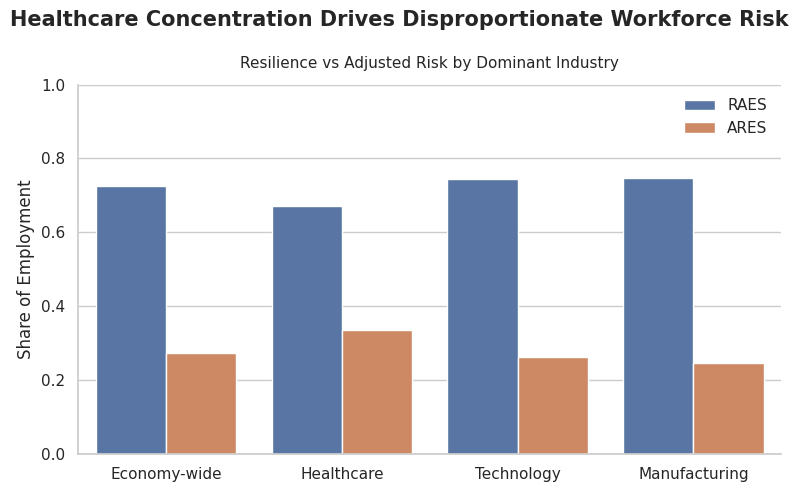

In [42]:


plot_df = report.copy()

# Mapping segment
report["dominant_industry"] = report["dominant_industry"].replace({
    "Health care and social assistance": "Healthcare",
    "Information": "Technology"
})

# Starting plot
plot_df = plot_df.melt(
    id_vars=["dominant_industry"],
    value_vars=["RAES", "ARES"],
    var_name="Metric",
    value_name="Value"
)

fig, ax = plt.subplots(figsize=(8,5))

sns.barplot(data=plot_df, x="dominant_industry", y="Value", hue="Metric")



fig.suptitle(
    "Healthcare Concentration Drives Disproportionate Workforce Risk",
    fontsize=15,
    fontweight="bold",
    y=0.98
)

ax.set_title(
    "Resilience vs Adjusted Risk by Dominant Industry",
    fontsize=11,
    pad=12
)


plt.ylim(0,1)
plt.ylabel("Share of Employment")
plt.xlabel("")
plt.legend(frameon=False)
sns.despine()
plt.tight_layout()
plt.show()

### Strategic Interpretation

* At the aggregate level, 72.6% of simulated employment is supported by structurally resilient workforce exposure.
* However, healthcare-dominant firms exhibit materially lower resilience (0.67) and the highest sensitivity-adjusted downside risk (0.34).
* Despite representing the largest employment share, healthcare accounts for a disproportionate share of aggregate workforce risk.
* Manufacturing and Information segments exhibit stronger resilience and lower adjusted risk exposure, suggesting more stable workforce dynamics under current conditions.

This illustrates how sector concentration can amplify macro-level workforce vulnerability even when aggregate resilience appears elevated.

## Statistical Modeling - Drivers of Net Hiring

### Preparing Data

In [ ]:
model_df = df_valid.sort_values(["industry", "date"])

# Log employment growth
model_df["employment_growth"] = (
    model_df.groupby("industry")["employment"]
            .transform(lambda x: np.log(x) - np.log(x.shift(1)))
)

# Lag predictors within industry
model_df["lag_hire_volatility"] = (
    model_df.groupby("industry")["hire_volatility"].shift(1)
)

model_df["lag_separation_rate"] = (
    model_df.groupby("industry")["separation_rate"].shift(1)
)

# Drop missing values from differencing and lagging
model_df = model_df.dropna(subset=[
    "employment_growth",
    "lag_hire_volatility",
    "lag_separation_rate"
])

### Estimating Fixed Effects Model

$$
\Delta \ln E_{it}
=
\beta_1 \, \text{Volatility}_{i,t-1}
+
\beta_2 \, \text{SeparationRate}_{i,t-1}
+
\alpha_i
+
\gamma_t
+
\varepsilon_{it}
$$

**Where:**

- $\Delta \ln E_{it}$ = employment growth in industry $i$ at time $t$  
- $\alpha_i$ = industry fixed effects  
- $\gamma_t$ = time fixed effects  
- Predictors are lagged

**Core Economic Question:** Does workforce instability today predict employment contraction tomorrow?

**Why Log Employment Growth:** makes coefficients interpretable as percentage effects and normalizes across industries of different sizes

**Why Include Industry Fixed Effects:** Industries are different structurally, without FE coefficients would mix structural differences with dynamic effects.

**Why Include Time Fixed Effects:** Time FE control for economy-wide shocks (recessions, pandemic, etc.).

**Why Cluster Standard Errors:** This can help handle serial correlation within industries (downward trends this month likely point to continued downward trends) and heteroskedasticity in volatility across indutries (large swings in volatility in Information versus little to no swings in volatility in Healthcare).

In [ ]:
# Converting date from period to timestamp
model_df = model_df.copy()
model_df["date_fe"] = model_df["date"].astype(str)

# Running Model
model = smf.ols(
    formula="""
        employment_growth
        ~ lag_hire_volatility
        + lag_separation_rate
        + C(industry)
        + C(date_fe)
    """,
    data=model_df
).fit(
    cov_type="cluster",
    cov_kwds={"groups": model_df["industry"]}
)

model.summary()

#### Coefficient Interpretation

**lag_hire_volatility**

- Coefficient: 0.257  
- Std. Err.: 0.127  
- p-value: 0.044  
- Statistically significant at the 5% level  

**Interpretation:**  
A one-unit increase in scaled hiring volatility is associated with a 0.26 percentage point increase in subsequent employment growth.

This positive relationship suggests that elevated hiring volatility may reflect labor market dynamism rather than fragility. During expansionary periods, hiring activity often accelerates unevenly across firms and occupations, generating volatility that precedes continued aggregate growth.

---

**lag_separation_rate**

- Coefficient: -0.042  
- Std. Err.: 0.033  
- p-value: 0.196  
- Not statistically significant at the 5% level  

**Interpretation:**  
Higher separation rates are not statistically associated with subsequent employment growth in this specification.

---

**Note on Inference:**  
Standard errors are clustered at the industry level. Given the limited number of industries in this subset, results should be interpreted as directional rather than causal or inferential.

### **Big Picture Takeaway**

**When hiring volatility rises above its norm (holding macro conditions constant) → employment growth increases in the next period.**

This suggests that the 6-month rolling volatility of the hire rate is not capturing labor market fragility. Instead, it appears to reflect labor market dynamism — periods of intensified hiring adjustment associated with expansion rather than contraction.